<a href="https://colab.research.google.com/github/Heinrich-Z/OttoGeo/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect this notebook to google cloud
# select the correct GPU before connecting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# check the current working directory
import os
os.getcwd()

'/content'

In [ ]:
# make sure the working directory is at ./OttoGeo
os.chdir('drive/MyDrive/Colab Notebooks/OttoGeo')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/OttoGeo'

<KeysViewHDF5 ['class_names', 'images', 'labels']>
Dataset Length: 2800
Label: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Location: b'HW_718'


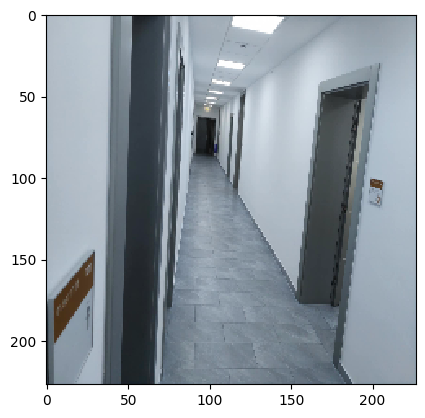

In [ ]:
# check the dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File('dataset/train_dataset.h5', 'r') as hf:
    print(hf.keys())
    print("Dataset Length: " + str(len(hf['images'])))
    images = np.array(hf['images'])
    labels = np.array(hf['labels'])
    class_names = np.array(hf['class_names'])

    # show an example
    plt.imshow(images[167].transpose(1, 2, 0), interpolation='nearest')
    print("Label: " + str(labels[167]))
    print("Location: " + str(class_names[np.argmax(labels[167])]))
    plt.show()

In [ ]:
# import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchvision.models import AlexNet_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
import torch.nn.functional as F
from datetime import datetime
import json
import os
import time
import logging

from custom_dataset import CustomDataset, DataTransform # defined in custom_dataset.py
from modulus import LeNet, AlexNet # defined in modulus.py

In [ ]:
# check the type of device, should be cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1275: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [ ]:
# setting up environment
torch.manual_seed(42)
cwd = os.getcwd()

# case name for the correct model selection
case_name = 'ResNet'

# loading hyperparameters
cfg_path = './conf/config.json'
with open(cfg_path, 'r') as f:
    cfg = json.load(f)

# setting up run destination
run_id = datetime.now().strftime(f"%Y%m%d-%H%M%S_{case_name}")
run_dir = os.path.join(cfg['output']['output_path'], run_id)
os.makedirs(run_dir, exist_ok=True)

print(f"Loaded configuration from {cfg_path}")

# model definition
if case_name == 'AlexNet':
    """
    model = AlexNet(
        in_channels=cfg['arch'][case_name]['in_channels'],
        num_classes=cfg['arch'][case_name]['num_classes'],
    ).to(device)
    """
    # use this part of the code for setting up a pre-trained model
    weights = AlexNet_Weights.DEFAULT
    model = models.alexnet(weights=weights)
    num_classes = cfg['arch'][case_name]['num_classes']
    model.classifier[6] = nn.Linear(4096, num_classes)

elif case_name == 'LeNet':
    model = LeNet(
        in_channels=cfg['arch'][case_name]['in_channels'],
        num_classes=cfg['arch'][case_name]['num_classes'],
    ).to(device)

elif case_name == 'ViT':
    # no self-made model definition for ViT as it's not a good idea to train vision transformer
    # use this part of the code for setting up a pre-trained model
    # weights = ViT_B_16_Weights.DEFAULT
    # model = vit_b_16(weights=weights)
    model = vit_b_16()
    num_classes = cfg['arch'][case_name]['num_classes']
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

elif case_name == 'ResNet':
    weights = ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    # model = resnet18()
    num_classes = cfg['arch'][case_name]['num_classes']
    model.fc = nn.Linear(512, num_classes)
    model = model.to(device)

else:
    model = None
    print("Failed to load model")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg['scheduler']['initial_lr'])
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: cfg['scheduler']['decay_rate']**step)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg['train']['max_epochs'])

# log the model detail
print("----------------------------")
print(f"Model Detail: ")
print(f"Model Name: {case_name}")
print(f"Number of Parameters: {sum(p.numel() for p in model.parameters())}")

# load dataset
dataset = CustomDataset(file_path=cfg['data']['train_path'], field_names=cfg['data']['field_names'], case_name=case_name)
# transform dataset (basic normalization)
dataset.transform = DataTransform(mean=cfg['data']['mean'], std=cfg['data']['std'], case_name=case_name)

# split dataset into training and validation, ratio = 9:1
dataset_train, dataset_val = random_split(dataset, [0.9, 0.1], generator=torch.Generator(device))

# move dataset to DataLoader for training loop
train_loader = DataLoader(dataset=dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True, generator=torch.Generator(device))
val_loader = DataLoader(dataset=dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True, generator=torch.Generator(device))

print("----------------------------")
print("Dataset Detail: ")
print(f"Batch Size: {cfg['train']['batch_size']}")
print(f"Training Batch Number: {len(train_loader)}")
print(f"Validation Batch Number: {len(val_loader)}")

Loaded configuration from ./conf/config.json
----------------------------
Model Detail: 
Model Name: ResNet
Number of Parameters: 11188311
----------------------------
Dataset Detail: 
Batch Size: 32
Training Batch Number: 79
Validation Batch Number: 9


In [ ]:
# training loop
print("----------------------------")
print("Training Details: ")
print(f"Training Epochs: {cfg['train']['max_epochs']}")
print(f"Initial Learning Rate: {cfg['scheduler']['initial_lr']}")
print(f"Learning Rate Decay Rate: {cfg['scheduler']['decay_rate']}")
print("----------------------------")

print("Training starts...")
total_start_time = time.time()

best_val_error = float('inf')
training_loss = []
validation_loss = []

for epoch in range(1, cfg['train']['max_epochs'] + 1):

    epoch_start_time = time.time()

    model.train()
    epoch_train_loss = 0.0

    """
    if epoch == cfg['train']['max_epochs'] // 2:
        optimizer.param_groups[0]['lr'] *= 0.1
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg['train']['max_epochs'] - epoch + 1)
    """

    for step, batch in zip(range(len(train_loader)), train_loader):
        inputs = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_epoch_loss = epoch_train_loss / len(train_loader)
    training_loss.append(avg_epoch_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch}\tTime: {epoch_duration:.2f}s\tLearning Rate = {optimizer.param_groups[0]['lr']:.3e}\tLoss = {avg_epoch_loss:.2e}")

    if epoch % cfg['train']['validation_epochs'] == 0:
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                inputs = batch[0].to(device)
                target = batch[1].to(device)

                output = model(inputs)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        avg_val_error = total_val_loss / len(val_loader)
        validation_loss.append(avg_val_error)

        print("----------------------------")
        print(f"Epoch {epoch}\tValidation Loss: {avg_val_error:.4f}")
        print("----------------------------")

        if avg_val_error < best_val_error:
            best_val_error = avg_val_error
            checkpoint_path = os.path.join(run_dir, 'best.pth')

            if os.path.exists(checkpoint_path):
                os.remove(checkpoint_path)

            torch.save(model.state_dict(), checkpoint_path)
            print("----------------------------")
            print(f"Saving the best validated model")
            print("----------------------------")

        # torch.save(model.state_dict(), os.path.join(run_dir, f'epoch_{epoch}.pth'))

    if epoch % cfg['scheduler']['scheduler_epoch'] == 0:
        scheduler.step()

torch.save(model.state_dict(), os.path.join(run_dir, 'final.pth'))
print("----------------------------")
print(f"Saving final model")
print("----------------------------")

total_end_time = time.time()
total_duration = total_end_time - total_start_time
formatted_duration = time.strftime("%H hour %M minutes %S seconds", time.gmtime(total_duration))
print(f"Training complete! Total time: {formatted_duration}")

In [ ]:
# testing
cwd = os.getcwd()

# loading hyperparameters
cfg_path = './conf/config.json'
with open(cfg_path, 'r') as f:
    cfg = json.load(f)

run_dir = 'runs/20260119-162517_ResNet' # the relative path of the selected runs
case_name = 'ResNet'

# model definition
if case_name == 'AlexNet':
    best_model = AlexNet(
        in_channels=cfg['arch'][case_name]['in_channels'],
        num_classes=cfg['arch'][case_name]['num_classes'],
    ).to(device)

elif case_name == 'LeNet':
    best_model = LeNet(
        in_channels=cfg['arch'][case_name]['in_channels'],
        num_classes=cfg['arch'][case_name]['num_classes'],
    ).to(device)

elif case_name == 'ViT':
    # weights = ViT_B_16_Weights.DEFAULT
    # best_model = vit_b_16(weights=weights)
    best_model = vit_b_16()
    num_classes = cfg['arch'][case_name]['num_classes']
    in_features = best_model.heads.head.in_features
    best_model.heads.head = nn.Linear(in_features, num_classes)

elif case_name == 'ResNet':
    best_model = resnet18()
    num_classes = cfg['arch'][case_name]['num_classes']
    best_model.fc = nn.Linear(512, num_classes)
    best_model.half().to(device)

else:
    best_model = None

# best validated model is stored with name 'best'
best_model_path = os.path.join(run_dir, 'final.pth')
if os.path.exists(best_model_path):
    best_model.load_state_dict(torch.load(best_model_path, weights_only=True, map_location=torch.device('cpu')))
    best_model.eval()
else:
    print("No best model exists")

# load testing dataset
test_dataset = CustomDataset(file_path=cfg['data']['test_path'], field_names=cfg['data']['field_names'], case_name=case_name)
test_dataset.transform = DataTransform(mean=cfg['data']['mean'], std=cfg['data']['std'], case_name=case_name)
test_loader = DataLoader(dataset=test_dataset, batch_size=cfg['train']['batch_size'], shuffle=True, generator=torch.Generator(device))

# testing over the dataset
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device).half()
        targets = batch[1].to(device).half()

        outputs = best_model(inputs)
        _, prediction = torch.max(outputs.data, 1)

        total += targets.size(0)
        for i in range(targets.size(0)):
            correct += int(targets[i][prediction[i]].item())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 86.67%


In [ ]:
param_size = 0
for param in best_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in best_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 21.358MB


By Tianao Zhang